<a href="https://colab.research.google.com/github/Zhangjt9317/Laidata/blob/master/proj2_car_classification_new.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Note: Please "Copy" this notebook before you work on it !!!!
In File   ->   Save a copy in Drive

# 1.introduction

This project is about car classification for [stanford car dataset](https://ai.stanford.edu/~jkrause/cars/car_dataset.html). The Cars dataset contains 16,185 images of 196 classes of cars. The data is split into 8,144 training images and 8,041 testing images, where each class has been split roughly in a 50-50 split. Classes are typically at the level of Make, Model, Year, e.g. 2012 Tesla Model S or 2012 BMW M3 coupe.

It is difficult to directly train deep learning model on this dataset because the limited number of images. Thus we decide to use transfer learning, a common approch used in deep learning to utilize the pretrained model on [imagenet](http://www.image-net.org/) and fine-tune on our own dataset, i.e. car dataset.

This project can show you how to train and fine-tune a deep learning model using kera (tensorflow backend).

![](https://ai.stanford.edu/~jkrause/cars/class_montage.jpg)

## 1.1 Transfer Learning
Transfer learning is one of the most widely used technologies in deep learning and computer vision. If you are not familar with the concept of transfer learning, please refer to our course materials.

![](https://cdn-images-1.medium.com/max/2000/1*9GTEzcO8KxxrfutmtsPs3Q.png)

# Note
use the following keras version for fixed batch norm in transfer learning.

In [0]:
!pip install -U --force-reinstall --no-dependencies  git+https://github.com/datumbox/keras@bugfix/trainable_bn

  Cloning https://github.com/datumbox/keras (to revision bugfix/trainable_bn) to /tmp/pip-req-build-c2sefhem
  Running command git clone -q https://github.com/datumbox/keras /tmp/pip-req-build-c2sefhem
  Running command git checkout -b bugfix/trainable_bn --track origin/bugfix/trainable_bn
  Switched to a new branch 'bugfix/trainable_bn'
  Branch 'bugfix/trainable_bn' set up to track remote branch 'bugfix/trainable_bn' from 'origin'.
  Created wheel for Keras: filename=Keras-2.2.4-cp36-none-any.whl size=311046 sha256=b3c5e2eb407e134c8031b04ab6b82e17194fdafe8fd0e906283f64cfdd63d1a2
  Stored in directory: /tmp/pip-ephem-wheel-cache-dwmzdiyt/wheels/36/5d/50/99c268bf64c1394c4f5b743164e4e515ab30290a523595ac47
Successfully built Keras
  Found existing installation: Keras 2.2.5
    Uninstalling Keras-2.2.5:
      Successfully uninstalled Keras-2.2.5


# 2.Import & read data

## 2.1 mount google drive to colab

In [0]:
# mount goolge drive to colab
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
!cp -rvf /content/drive/My\ Drive/car_dataset /content/

'/content/drive/My Drive/car_dataset' -> '/content/car_dataset'
'/content/drive/My Drive/car_dataset/devkit' -> '/content/car_dataset/devkit'
'/content/drive/My Drive/car_dataset/test' -> '/content/car_dataset/test'
'/content/drive/My Drive/car_dataset/test/135' -> '/content/car_dataset/test/135'
'/content/drive/My Drive/car_dataset/test/135/04354.jpg' -> '/content/car_dataset/test/135/04354.jpg'
'/content/drive/My Drive/car_dataset/test/135/06609.jpg' -> '/content/car_dataset/test/135/06609.jpg'
'/content/drive/My Drive/car_dataset/test/135/03981.jpg' -> '/content/car_dataset/test/135/03981.jpg'
'/content/drive/My Drive/car_dataset/test/135/02447.jpg' -> '/content/car_dataset/test/135/02447.jpg'
'/content/drive/My Drive/car_dataset/test/135/02693.jpg' -> '/content/car_dataset/test/135/02693.jpg'
'/content/drive/My Drive/car_dataset/test/135/05677.jpg' -> '/content/car_dataset/test/135/05677.jpg'
'/content/drive/My Drive/car_dataset/test/135/00278.jpg' -> '/content/car_dataset/test/135

## 2.2 Copy file from google drive to colab

In [0]:
from tensorflow import gfile
import os
import zipfile
import tarfile

In [0]:
%%time
if os.path.exists("drive/My Drive/car_dataset.tar"):
  gfile.Copy("drive/My Drive/car_dataset.tar", "./car_dataset.tar", )
print(os.listdir("."))

['.config', 'drive', 'car_dataset.tar', 'sample_data']
CPU times: user 1.74 ms, sys: 5.12 s, total: 5.12 s
Wall time: 37.7 s


## 2.3 Extract dataset files

In [0]:
%%time
tar = tarfile.open("./car_dataset.tar", "r")
tar.extractall(path=".")

CPU times: user 7.08 s, sys: 9.86 s, total: 16.9 s
Wall time: 30 s


In [0]:
print(os.listdir("./car_dataset"))

['cars_test', 'devkit', 'test', '.DS_Store', 'train', 'read_label.py', 'cars_train']


# 3.Build model

## 3.1 Load packages

The keras and tensorflow have been pre-installled on colab, and we do not need re-install these packages.

In [0]:
from keras.preprocessing import image
from keras.applications import vgg16
from keras.applications import vgg19
from keras.applications import resnet50
from keras.applications import inception_v3
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from keras.models import Model, Sequential
from keras import optimizers
from keras.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping
# import argparse
from time import time

from skimage import exposure, color

from keras import backend as K
# K.common.image_dim_ordering()
K.set_image_dim_ordering('tf')

Using TensorFlow backend.


## 3.2 Initalize model
In this step, we will initalize our architecture. We use predefined architectures such as resnet50/vgg19/inception, you can also use your own architectures.

In [0]:
def init_model(train_dir, val_dir, batch_size=32, model_name='vgg19', num_class=196, img_size=224):
    """
    initialize cnn model and training and validation data generator
    parms:
        args: parsed commandline arguments
    return:
        model: initialized model
        train_generator: training data generator
        validation_generator: validation data generator
    """
    

    print('loading the model and the pre-trained weights...')

    # load base model
    if model_name == 'vgg19':
        base_model = vgg19.VGG19(include_top=False, weights='imagenet', input_shape = (img_size, img_size, 3)) # need specify input_shape
        # this preprocess_input is the default preprocess func for given network, you can change it or implement your own 
        # use inception_v3 preprocess for vgg16, it seems that it works better than vgg16.preprocess_input
        preprocess_input = vgg19.preprocess_input

    # initalize training image data generator'
    # you can also specify data augmentation here
    train_datagen = image.ImageDataGenerator(
        # width_shift_range=0.1,
        # height_shift_range=0.1,
        # samplewise_center=True,l
        # samplewise_std_normalization=True,
        # rescale=1./255,
        preprocessing_function=preprocess_input,
        # rotation_range=30,
        # shear_range=0.1,
        # zoom_range=0.1,
        # vertical_flip=True,
        horizontal_flip=True
        )

    # initalize validation image data generator
    # you can also specify data augmentation here
    validation_datagen = image.ImageDataGenerator(
        # samplewise_center=True,
        # samplewise_std_normalization=True
        # rescale=1./255
        preprocessing_function=preprocess_input # preprocess_input
        )

    train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(img_size, img_size),
        batch_size=batch_size,
        class_mode='categorical')     

    validation_generator = validation_datagen.flow_from_directory(
        val_dir,
        # color_mode='grayscale',  # 'rgb'
        target_size=(img_size, img_size),
        batch_size=batch_size,
        class_mode='categorical')

    # fix base_model layers
    for layer in base_model.layers:
        layer.trainable = False

    # added some customized layers for your own data
    x = base_model.output
    if model_name == 'vgg19':
        x = GlobalAveragePooling2D(name='avg_pool')(x)
        # x = Flatten(name='flatten')(x)
        # x = Dense(512, activation='relu', name='fc1-pretrain')(x)
        x = Dense(256, activation='relu', name='fc2-pretrain')(x)
        x = Dropout(0.3, name='dropout')(x)

    # added softmax layer
    predictions = Dense(num_class, activation='softmax', name='predictions')(x)

    model = Model(inputs=base_model.input, outputs=predictions)
    
    sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
    adam = optimizers.Adam()
    # model.compile(loss='mean_squared_error', optimizer=sgd)
    model.compile(loss="categorical_crossentropy", optimizer=adam, metrics=["accuracy"])

    return model, train_generator, validation_generator

## 3.3 train model
This part defines the function to train our model. We can specify the training parameters such as number of epochs, optimizers, and etc here.

In [0]:
def train(model, train_generator, validation_generator, num_class=196, model_name='vgg19', batch_size=32, epochs=30, suffix='laioffer'):
    """
    train the model
    parms:
        model: initialized model
        train_generator: training data generator
        validation_generator: validation data generator
        args: parsed command line arguments
    return:
    """
    # define number of steps/iterators per epoch
    stepsPerEpoch = train_generator.samples / batch_size
    validationSteps= validation_generator.samples / batch_size

    # save the snapshot of the model to local drive
    pretrain_model_name = 'pretrained_{}_{}_{}_{}.h5'.format(model_name, num_class, epochs, suffix)
    # visualize the training process
    tensorboard = TensorBoard(log_dir="logs/{}_pretrain_{}".format(model_name, time()), histogram_freq=0, write_graph=True)
    checkpoint = ModelCheckpoint(pretrain_model_name, monitor='val_acc', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
    earlystopping = EarlyStopping(monitor='acc', patience=5)
    callbacks_list = [checkpoint, tensorboard, earlystopping]

    history = model.fit_generator(
        train_generator,
        steps_per_epoch=stepsPerEpoch,
        epochs=epochs,
        callbacks = callbacks_list,
        validation_data = validation_generator,
        validation_steps=validationSteps)
    return history

## 3.4 Fine-tune model
This part defines the function to fine-tune the pre-trained model on our datset. If you do not have enough data, you may consider fine-tune less layers.

In [0]:
 def fine_tune(model, train_generator, validation_generator, num_class=196, model_name='vgg19', batch_size=32, epochs=50, suffix='laioffer'):
    """
    fine tune the model
    parms:
        model: initialized model
        train_generator: training data generator
        validation_generator: validation data generator
        args: parsed command line arguments
    return:
    """
    # for specific architectures, define number of trainable layers
    if model_name == 'vgg19':
        trainable_layers = 6

    for layer in model.layers[:-1*trainable_layers]:
        layer.trainable = False

    for layer in model.layers[-1*trainable_layers:]:
        layer.trainable = True

    finetune_model_name = 'finetuned_{}_{}_{}_{}.h5'.format(model_name, num_class, epochs, suffix)
    tensorboard = TensorBoard(log_dir="logs/{}_finetune_{}".format(model_name, time()), histogram_freq=0, write_graph=True)
    checkpoint = ModelCheckpoint(finetune_model_name, monitor='val_acc', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
    earlystopping = EarlyStopping(monitor='acc', patience=5)
    callbacks_list = [checkpoint, tensorboard, earlystopping]

    model.compile(loss="categorical_crossentropy", optimizer=optimizers.SGD(lr=0.0001, momentum=0.9),metrics=["accuracy"])

    stepsPerEpoch = train_generator.samples / batch_size
    validationSteps= validation_generator.samples / batch_size
    history = model.fit_generator(
        train_generator,
        steps_per_epoch=stepsPerEpoch,
        epochs=epochs,
        callbacks = callbacks_list,
        validation_data = validation_generator,
        validation_steps=validationSteps)
    return history

# 4.Experiment

## 4.1.Train/fine-tune model
We can start to train and fine-tune our model here.

In [0]:
# initialize model
model, train_generator, validation_generator = init_model(train_dir='car_dataset/train', model_name='vgg19', val_dir='car_dataset/test', num_class=196)
# pretrain model
train(model, train_generator, validation_generator, num_class=196, model_name='vgg19', epochs=15)
# fine-tune model   
history = fine_tune(model, train_generator, validation_generator, num_class=196, model_name='vgg19', epochs=30)

loading the model and the pre-trained weights...




80142336/80134624 [==============================] - 1s 0us/step


Found 8144 images belonging to 196 classes.
Found 8041 images belonging to 196 classes.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/15
255/254 [==============================] - 213s 836ms/step - loss: 5.6657 - acc: 0.0148 - val_loss: 4.9366 - val_acc: 0.0327

Epoch 00001: val_acc improved from -inf to 0.03271, saving model to pretrained_vgg19_196_15_laioffer.h5
Epoch 2/15
255/254 [==============================] - 205s 803ms/step - loss: 4.6852 - acc: 0.0515 - val_loss: 4.2090 - val_acc: 0.0869

Epoch 00002: val_acc improved from 0.03271 to 0.08693, saving model to pretrained_vgg19_196_15_laioffer.h5
Epoch 3/15
255/254 [==============================] - 205s 803ms/step - loss: 4.1032 - acc: 0.0

## 4.2 Results

### 4.2.1 Accuracy

In [0]:
scores = model.evaluate_generator(validation_generator, verbose=1, steps=len(validation_generator))
print("Validation accuracy = ", scores[1])

252/252 [==============================] - 111s 441ms/step
Validation accuracy =  0.4513120258896672


### 4.2.2 Classification report

In [0]:
import numpy as np
# predicted_label_probs = model.predict_generator(validation_generator, verbose=1)
# predicted_labels = np.argmax(predicted_label_probs, axis=1)

from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

test_datagen = image.ImageDataGenerator(
    preprocessing_function=vgg19.preprocess_input # preprocess_input
    )

test_generator = test_datagen.flow_from_directory(
    "car_dataset/test",
    target_size=(224, 224),
    batch_size=1,
    shuffle=False,    # keep data in same order as labels
    class_mode='categorical')# only data, no labels

true_labels = test_generator.classes

predicted_label_probs = model.predict_generator(test_generator, verbose=1,steps=len(test_generator))
predicted_labels = np.argmax(predicted_label_probs, axis=1)
# predicted_labels 

Found 8041 images belonging to 196 classes.
8041/8041 [==============================] - 247s 31ms/step


In [0]:
label_map = (test_generator.class_indices)
# label_map

In [0]:
# print(confusion_matrix(true_labels, predicted_labels))
print(classification_report(true_labels, predicted_labels))
# print("Accuracy = ", accuracy_score(true_labels, predicted_labels))

              precision    recall  f1-score   support

           0       0.83      0.91      0.87        44
           1       0.18      0.06      0.09        33
           2       0.58      0.45      0.51        33
           3       0.38      0.57      0.46        42
           4       0.68      0.72      0.70        39
           5       0.68      0.49      0.57        39
           6       0.44      0.52      0.48        42
           7       0.46      0.37      0.41        43
           8       0.82      0.68      0.75        41
           9       0.56      0.43      0.49        44
          10       0.57      0.75      0.65        44
          11       0.51      0.41      0.46        44
          12       0.55      0.71      0.62        38
          13       0.41      0.37      0.39        43
          14       0.37      0.60      0.45        42
          15       0.39      0.42      0.40        45
          16       0.50      0.57      0.53        42
          17       0.57    

### 4.2.3 Visualize confusion matrix

In [0]:
import matplotlib.pyplot as plt
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

Normalized confusion matrix
[[1.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         1.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         1.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.85714286 0.03571429 0.
  0.10714286 0.         0.         0.        ]
 [0.         0.         0.         0.06060606 0.84848485 0.
  0.09090909 0.         0.         0.        ]
 [0.         0.         0.         0.         0.16666667 0.63333333
  0.2        0.         0.         0.        ]
 [0.         0.         0.         0.04       0.         0.08
  0.88       0.         0.         0.        ]
 [0.         0.05882353 0.         0.         0.         0.
  0.         0.94117647 0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         1.         0.        ]

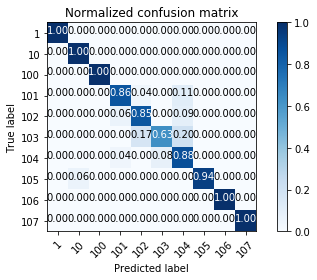

In [0]:
cnf_matrix = confusion_matrix(true_labels, predicted_labels)
# Plot non-normalized confusion matrix
# plt.figure()
# plot_confusion_matrix(cnf_matrix, classes=list(label_map.keys()),
#                       title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix[:10,:10], classes=list(label_map.keys())[:10], normalize=True,
                      title='Normalized confusion matrix')

plt.show()

### 4.2.4 Visualize training history

In [0]:
def plot_history(history):
    loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' not in s]
    val_loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' in s]
    acc_list = [s for s in history.history.keys() if 'acc' in s and 'val' not in s]
    val_acc_list = [s for s in history.history.keys() if 'acc' in s and 'val' in s]
    
    if len(loss_list) == 0:
        print('Loss is missing in history')
        return 
    
    ## As loss always exists
    epochs = range(1,len(history.history[loss_list[0]]) + 1)
    
    ## Loss
    plt.figure(1)
    for l in loss_list:
        plt.plot(epochs, history.history[l], 'b', label='Training loss (' + str(str(format(history.history[l][-1],'.5f'))+')'))
    for l in val_loss_list:
        plt.plot(epochs, history.history[l], 'g', label='Validation loss (' + str(str(format(history.history[l][-1],'.5f'))+')'))
    
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    ## Accuracy
    plt.figure(2)
    for l in acc_list:
        plt.plot(epochs, history.history[l], 'b', label='Training accuracy (' + str(format(history.history[l][-1],'.5f'))+')')
    for l in val_acc_list:    
        plt.plot(epochs, history.history[l], 'g', label='Validation accuracy (' + str(format(history.history[l][-1],'.5f'))+')')

    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

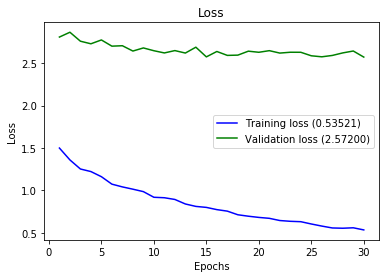

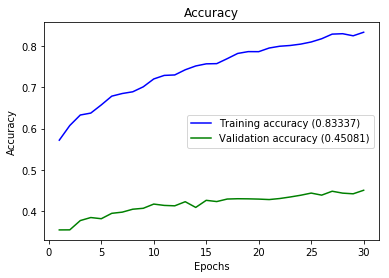

In [0]:
plot_history(history)

In [0]:
# from sklearn.metrics import recall_score, classification_report, auc, roc_curve
# cm = confusion_matrix(true_labels, predicted_labels)
# print(cm)


# plt.plot(history.history['acc'])
# plt.plot(history.history['val_acc'])
# plt.title('Model accuracy')
# plt.ylabel('Accuracy')
# plt.xlabel('Epoch')
# plt.legend(['Train', 'Test'], loc='upper left')
# plt.show()

In [0]:
# predicted_labels

### 4.2.5 Save model

In [0]:
model.save("model.h5")

### 4.2.6 Load model

In [0]:
from keras.models import load_model
new_model = load_model("model.h5")

In [0]:
new_predicted_label_probs = new_model.predict_generator(test_generator, verbose=1,steps=len(test_generator))
new_predicted_labels = np.argmax(new_predicted_label_probs, axis=1)

8041/8041 [==============================] - 247s 31ms/step


In [0]:
print(confusion_matrix(true_labels, predicted_labels))
print(classification_report(true_labels, predicted_labels))
print("Accuracy = ", accuracy_score(true_labels, predicted_labels))

[[40  0  0 ...  0  0  0]
 [ 0  2  0 ...  0  0  0]
 [ 0  0 15 ...  0  0  0]
 ...
 [ 0  0  0 ... 19  0  0]
 [ 0  0  0 ...  1 17  0]
 [ 0  0  0 ...  0  0 17]]
              precision    recall  f1-score   support

           0       0.83      0.91      0.87        44
           1       0.18      0.06      0.09        33
           2       0.58      0.45      0.51        33
           3       0.38      0.57      0.46        42
           4       0.68      0.72      0.70        39
           5       0.68      0.49      0.57        39
           6       0.44      0.52      0.48        42
           7       0.46      0.37      0.41        43
           8       0.82      0.68      0.75        41
           9       0.56      0.43      0.49        44
          10       0.57      0.75      0.65        44
          11       0.51      0.41      0.46        44
          12       0.55      0.71      0.62        38
          13       0.41      0.37      0.39        43
          14       0.37      0.60